In [40]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import random as rn
import tensorflow
from keras.optimizers import Adam
from PIL import Image
from keras.utils.data_utils import get_file
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import SVG
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.utils.vis_utils import model_to_dot
#from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,BatchNormalization,Dropout,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

In [2]:
resnet_weights_path = 'C:/Users/hardikarora/Desktop/Loveleen Journal/My Journal/174469_505351_bundle_archive/Resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
vgg16_weights_path="C:/Users/hardikarora/Desktop/Loveleen Journal/My Journal/174469_505351_bundle_archive/VGG16/vgg16_weights_tf_dim_ordering_tf_kernels.h5"

In [3]:
print(os.listdir("C:/Users/hardikarora/Desktop/Loveleen Journal/My Journal/174469_505351_bundle_archive"))


['174469_505351_bundle_archive.zip', 'data', 'Resnet50', 'test', 'train', 'VGG16']


In [4]:
def Dataset_loader(DIR,RESIZE):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img)/255.)
    return IMG

In [5]:
benign_train = np.array(Dataset_loader('C:/Users/hardikarora/Desktop/Loveleen Journal/My Journal/174469_505351_bundle_archive/train/benign',224))
malign_train = np.array(Dataset_loader('C:/Users/hardikarora/Desktop/Loveleen Journal/My Journal/174469_505351_bundle_archive/train/malignant',224))
benign_test = np.array(Dataset_loader('C:/Users/hardikarora/Desktop/Loveleen Journal/My Journal/174469_505351_bundle_archive/test/benign',224))
malign_test = np.array(Dataset_loader('C:/Users/hardikarora/Desktop/Loveleen Journal/My Journal/174469_505351_bundle_archive/test/malignant',224))


100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 568.13it/s]


In [6]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

In [24]:
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

In [8]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

In [9]:
x_train=X_train[1000:]
x_val=X_train[:1000]
y_train=Y_train[1000:]
y_val=Y_train[:1000]

In [25]:
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

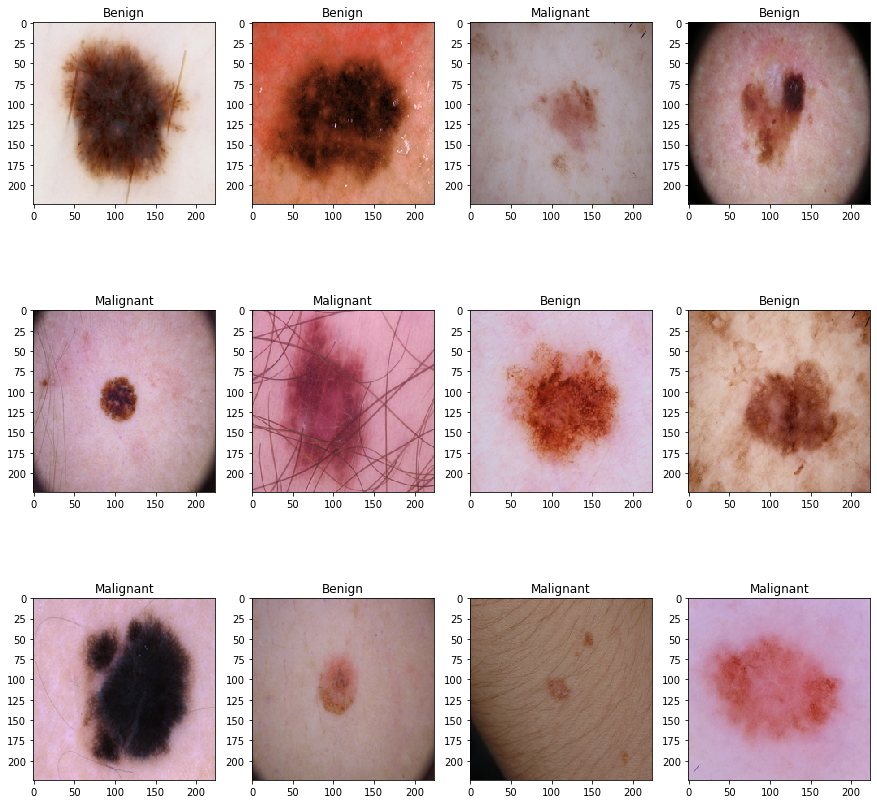

In [11]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if Y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False) 

In [13]:
vgg16_model = tensorflow.keras.applications.vgg16.VGG16()

In [14]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
model = Sequential()
for layer in vgg16_model.layers[:-1]: # go through until last layer
    model.add(layer)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [17]:
for layer in model.layers:
    layer.trainable=False
model.add(Dense(1, activation='softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [19]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.7)

In [22]:
batch_size=64
epochs=25
History = model.fit(x_train,y_train,batch_size=batch_size,validation_data=(x_val,y_val),
                              epochs= epochs, steps_per_epoch=x_train.shape[0]//batch_size,verbose=2
                             ) 

Epoch 1/25
25/25 - 180s - loss: 0.0000e+00 - accuracy: 0.4387 - val_loss: 0.0000e+00 - val_accuracy: 0.4780
Epoch 2/25
25/25 - 151s - loss: 0.0000e+00 - accuracy: 0.4425 - val_loss: 0.0000e+00 - val_accuracy: 0.4780
Epoch 3/25
25/25 - 149s - loss: 0.0000e+00 - accuracy: 0.4367 - val_loss: 0.0000e+00 - val_accuracy: 0.4780
Epoch 4/25
25/25 - 149s - loss: 0.0000e+00 - accuracy: 0.4418 - val_loss: 0.0000e+00 - val_accuracy: 0.4780
Epoch 5/25
25/25 - 149s - loss: 0.0000e+00 - accuracy: 0.4367 - val_loss: 0.0000e+00 - val_accuracy: 0.4780
Epoch 6/25
25/25 - 149s - loss: 0.0000e+00 - accuracy: 0.4431 - val_loss: 0.0000e+00 - val_accuracy: 0.4780
Epoch 7/25
25/25 - 149s - loss: 0.0000e+00 - accuracy: 0.4336 - val_loss: 0.0000e+00 - val_accuracy: 0.4780
Epoch 8/25
25/25 - 149s - loss: 0.0000e+00 - accuracy: 0.4437 - val_loss: 0.0000e+00 - val_accuracy: 0.4780
Epoch 9/25
25/25 - 149s - loss: 0.0000e+00 - accuracy: 0.4298 - val_loss: 0.0000e+00 - val_accuracy: 0.4780
Epoch 10/25
25/25 - 149s - l

In [14]:
model.add(VGG16(input_shape=(224,224,3),pooling='avg',weights='imagenet'))

In [23]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1000)              138357544 
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                64064     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [32]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy'])

TypeError: Unexpected keyword argument passed to optimizer: learning_rate

In [25]:
red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.7)

In [26]:
batch_size=16
epochs=25
History = model.fit(x_train,y_train,batch_size=batch_size,validation_data=(x_val,y_val),
                              epochs= epochs, steps_per_epoch=x_train.shape[0]//batch_size,verbose=2
                             ) 

Epoch 1/25
102/102 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.4945

KeyboardInterrupt: 

In [29]:
lists=[]
y_pred = model.predict(X_test)
for i in range(len(y_pred)):
    if y_pred[i][0]>0.5:
        lists.append(1)
    else:
        lists.append(0)
        
print(accuracy_score(Y_test, lists))

0.45454545454545453


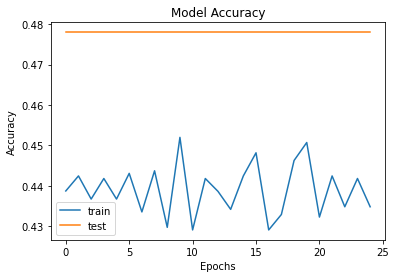

In [30]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [31]:
confusion_matrix(Y_test, lists) 

array([[  0, 360],
       [  0, 300]], dtype=int64)

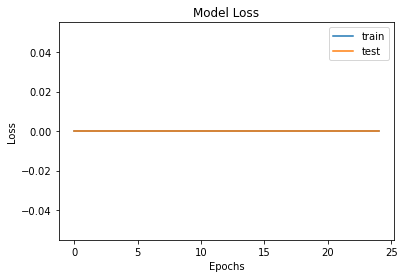

In [32]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

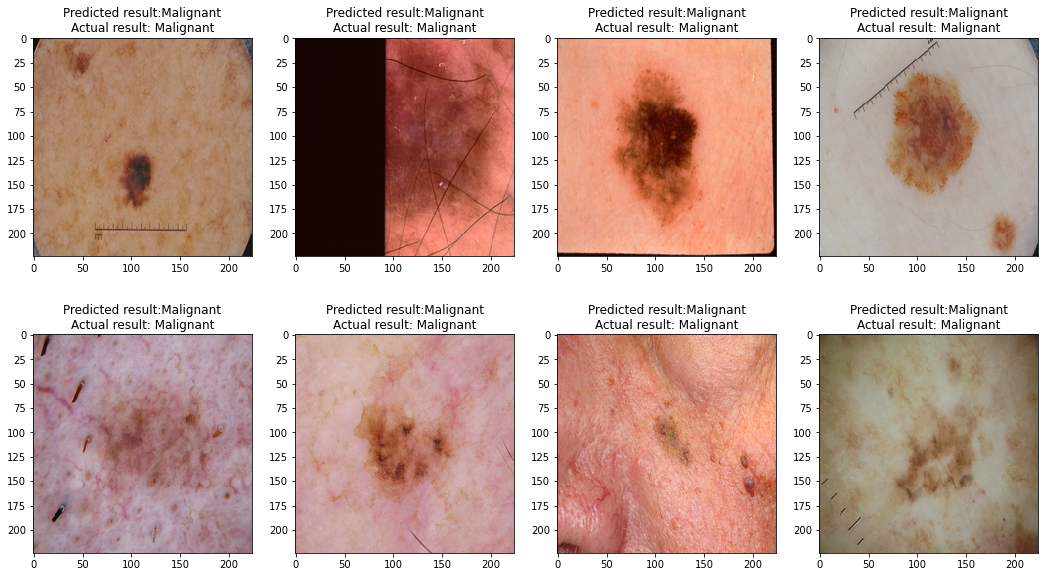

In [33]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(Y_test[i]==lists[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not Y_test[i]==lists[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(lists[prop_class[i]])
                       +"\n"+"Actual result: "+ Transfername(Y_test[prop_class[i]]))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()


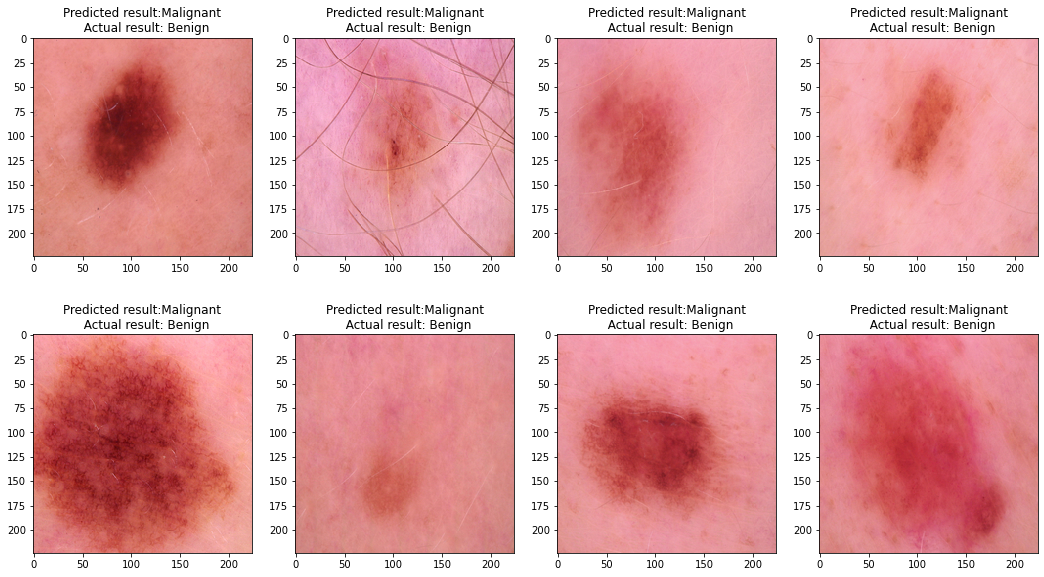

In [34]:
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2
for i in range(len(mis_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(lists[mis_class[i]])
                   +"\n"+"  Actual result: "+ Transfername(Y_test[mis_class[i]]))
    plt.imshow(X_test[mis_class[i]], interpolation='nearest')
plt.show()


In [41]:
def train_finetuned_model():
    file_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5', vgg16_weights_path, cache_subdir='VGG16')
    print('Building VGG16 (no-top) model to generate bottleneck features')
    vgg16_notop = build_vgg_16()
    vgg16_notop.load_weights(file_path)
    for _ in range(6):
        vgg16_notop.pop()
    vgg16_notop.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    train_batches = get_batches('C:/Users/HARDIK ARORA/Desktop/174469_505351_bundle_archive/train', shuffle=False, class_mode=None)
    train_labels = np.array([0]*1000 + [1]*1000)
    bottleneck_train = vgg16_notop.predict_generator(train_batches, steps=2000 // BATCH_SIZE)
    
    valid_batches = get_batches('C:/Users/HARDIK ARORA/Desktop/174469_505351_bundle_archive/test', shuffle=False, class_mode=None)
    valid_labels = np.array([0]*400 + [1]*400)
    bottleneck_valid = vgg16_notop.predict_generator(valid_batches, steps=800 // BATCH_SIZE)
    
    print('Training top model on bottleneck features')
    top_model = Sequential()
    top_model.add(Flatten(input_shape=bottleneck_train.shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    top_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    top_model.fit(bottleneck_train, train_labels, 
                  batch_size=32, epochs=25, 
                  validation_data=(bottleneck_valid, valid_labels))
    print('Concatenate new VGG16 (without top layer) with pretrained top model')
    vgg16_fine = build_vgg_16()    
    vgg16_fine.load_weights(file_path)
    for _ in range(6):
        vgg16_fine.pop()
    vgg16_fine.add(Flatten(name='top_flatten'))    
    vgg16_fine.add(Dense(256, activation='relu', name='top_dense'))
    vgg16_fine.add(Dropout(0.5, name='top_dropout'))
    vgg16_fine.add(Dense(1, activation='sigmoid', name='top_sigmoid'))
    for i, layer in enumerate(reversed(top_model.layers), 1):
        pretrained_weights = layer.get_weights()
        vgg16_fine.layers[-i].set_weights(pretrained_weights)
    for layer in vgg16_fine.layers[:26]:
        layer.trainable = False
    vgg16_fine.compile(optimizer=SGD(lr=1e-4, momentum=0.9),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])
    
    print('Train concatenated model on dogs/cats dataset sample')
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_batches = get_batches('train', gen=train_datagen, class_mode='binary')
    valid_batches = get_batches('valid', gen=test_datagen, class_mode='binary')
    vgg16_fine.fit_generator(train_batches,
                             steps_per_epoch=2000 // BATCH_SIZE,
                             epochs=50,
                             validation_data=valid_batches,
                             validation_steps=800 // BATCH_SIZE)
    return vgg16_fine


final_model = train_finetuned_model()

Exception: URL fetch failure on C:/Users/HARDIK ARORA/Desktop/174469_505351_bundle_archive/VGG16/vgg16_weights_tf_dim_ordering_tf_kernels.h5: None -- unknown url type: c